# 以策略梯度(Policy Gradient)演算法求解木棒台車
### 修改自[Policy Gradient in Reinforcement Learning](https://github.com/tsmatz/reinforcement-learning-tutorials/tree/master)

## 載入套件

In [2]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

## 以簡單的神經網路訂定行動策略機率模型

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PolicyPi(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()

        self.hidden = nn.Linear(4, hidden_dim)
        self.classify = nn.Linear(hidden_dim, 2)

    def forward(self, s):
        outs = self.hidden(s)
        outs = F.relu(outs)
        logits = self.classify(outs)
        return logits

policy_pi = PolicyPi().to(device)

## 載入木棒台車遊戲

In [4]:
env = gym.make("CartPole-v1")

## 定義隨機行動函數

In [5]:
# Pick up action with above distribution policy_pi
def pick_sample(s):
    with torch.no_grad():
        #   --> size : (1, 4)
        s_batch = np.expand_dims(s, axis=0)
        s_batch = torch.tensor(s_batch, dtype=torch.float).to(device)
        # Get logits from state
        #   --> size : (1, 2)
        logits = policy_pi(s_batch)
        #   --> size : (2)
        logits = logits.squeeze(dim=0)
        # From logits to probabilities
        probs = F.softmax(logits, dim=-1)
        # Pick up action's sample
        a = torch.multinomial(probs, num_samples=1)
        # Return
        return a.tolist()[0]

## 模型訓練

In [6]:
gamma = 0.99
reward_records = []
opt = torch.optim.AdamW(policy_pi.parameters(), lr=0.001)

# 模型訓練
for i in range(1000):
    # 先以隨機行動執行一回合
    done = False
    states = []
    actions = []
    rewards = []
    s, _ = env.reset()
    while not done:
        states.append(s.tolist())
        a = pick_sample(s)
        s, r, term, trunc, _ = env.step(a)
        done = term or trunc
        actions.append(a)
        rewards.append(r)
        
    # 記錄獎勵
    cum_rewards = np.zeros_like(rewards)
    reward_len = len(rewards)
    for j in reversed(range(reward_len)):
        cum_rewards[j] = rewards[j] + (cum_rewards[j+1]*gamma 
                                       if j+1 < reward_len else 0)

    # 訓練
    states = torch.tensor(states, dtype=torch.float).to(device)
    actions = torch.tensor(actions, dtype=torch.int64).to(device)
    cum_rewards = torch.tensor(cum_rewards, dtype=torch.float).to(device)
    opt.zero_grad()
    logits = policy_pi(states)
    # 將目標函數設為負值，將最大化變成最小化
    log_probs = -F.cross_entropy(logits, actions, reduction="none")
    loss = -log_probs * cum_rewards
    loss.sum().backward()
    opt.step()

    # Record total rewards in episode (max 500)
    print("Run episode {} with rewards {}".format(i, sum(rewards)), end="\r")
    reward_records.append(sum(rewards))

print("\nDone")
env.close()

Run episode 999 with rewards 381.0
Done


## 繪製趨勢圖

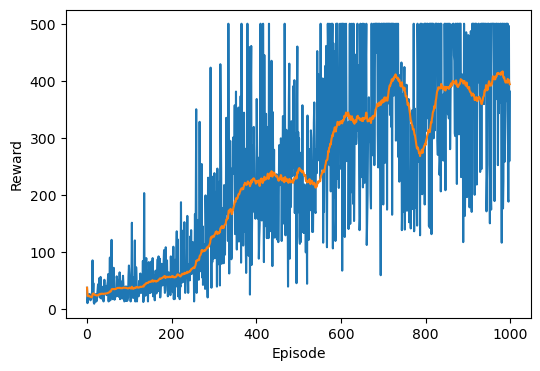

In [8]:
import matplotlib.pyplot as plt

# Generate recent 50 interval average
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 50:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-49:idx+1]
    average_reward.append(np.average(avg_list))
# Plot
plt.figure(figsize=(6,4))
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.plot(reward_records)
plt.plot(average_reward)
plt.show()